# Exporting graph using Vk api

In [113]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


As a graph, I used my own account in the social network vkontakte. To export the data, I created the VKontakte application, as well as several tokens, which allow making calls to Api. Also, to increase productivity, I took advantage of the advanced features of the VKontakte and created on their platform a special script that allows using 25 calls to api with 1 request. Code for exporting SN graph can be found in jupyter-notebook, but it needs tokens to work, so I pickled already downloaded one.

In [184]:
import random
import requests
# settings

tokens = ['x', 'x', 'x']

myid = '301053487'

def request_url(method_name, parameters, access_token=False):

    req_url = 'https://api.vk.com/method/{method_name}?{parameters}&v=5.74'.format(
        method_name=method_name, parameters=parameters)

    if access_token:
        req_url = '{}&access_token={token}'.format(req_url, token=random.choice(tokens))

    return req_url

def friends(id):

    r = requests.get(request_url('friends.get',
        'user_id=%s&fields=uid,sex' % id, True)).json()['response']
    
    r["items"] = list(filter((lambda x: 'deactivated' not in x.keys()), r['items']))
    return {item['id']: item for item in r['items']}

def cleaner(dct):
    """
    delete all blocked accounts
    """
    return {k:v for k, v in dct.items() if v != None}

parts = lambda lst, n: (lst[i:i + n] for i in iter(range(0, len(lst), n)))

make_targets = lambda lst: ",".join(str(x) for x in lst)

In [3]:
# my_friends = list(friends(myid).keys())
# result = {}
# for i in list(parts(my_friends, 25)):
#     r = requests.get(request_url('execute.massFriends', 'targets=%s' % make_targets(i), access_token=True)).json()["response"]

#     for x, vk_id in enumerate(i):
#         result[vk_id] = tuple(r[x]["items"]) if r[x] else None
        
# result = cleaner(result)

In [1]:
# result1 = {}
# all_friends = friends(myid)
# for i in list(parts(list(all_friends.keys()), 25)):
#     r = requests.get(request_url('execute.massMutual', 'source=%s&targets=%s' % (myid, make_targets(i)), access_token=True)).json()['response']	
#     for x, vk_id in enumerate(i):
#         result1[vk_id] = tuple(i for i in r[x]) if r[x] else None
# result1 = cleaner(result1)

import pickle

q = open('me2.pickle', 'rb')
all_friends, result1 = pickle.load(q)

Below you can see the resulting graph, where red verticles are women and blue are men. You can see quite clearly that the graph has a clear structure and has 3 clusters, which I can interpret as - my school friends, my friends from the university and my friends from the sports class.

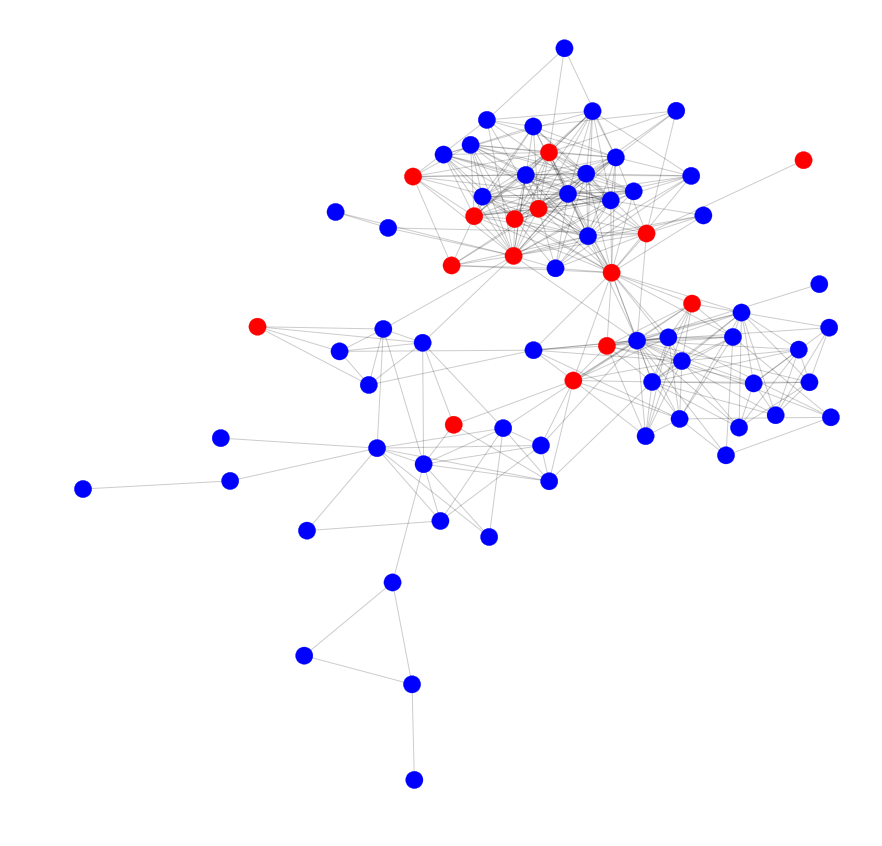

In [242]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.colors import ListedColormap
from matplotlib import colors as mcolors
my_cmap = ListedColormap(sns.color_palette("bright").as_hex())


import time

plt.figure(figsize=(15,15))

res = nx.from_dict_of_lists(result1)

nodes_sex = {key : item['sex'] for key, item in all_friends.items()} 

nx.set_node_attributes(res, nodes_sex, name='sex')
groups = set([1, 2])

mapping = { 1: 'red', 2: 'b' }
nodes = res.nodes()
colors = [mapping[res.node[n]['sex']] for n in nodes]

# nx.draw_kamada_kawai(res, alpha=0.9, with_labels=True, node_color=colors, cmap=plt.cm.jet)
pos = nx.kamada_kawai_layout(res)
ec = nx.draw_networkx_edges(res, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(res, pos, nodelist=nodes, node_color=colors, node_size=300, cmap=plt.cm.jet)

plt.axis('off')
plt.show()

Using another layout function, we can get a clearer presentation of clustering. This graph clearly shows that I have a friend who knows quite a lot of people both from my university and from school - this is the red vertex that connects 2 large clusters.

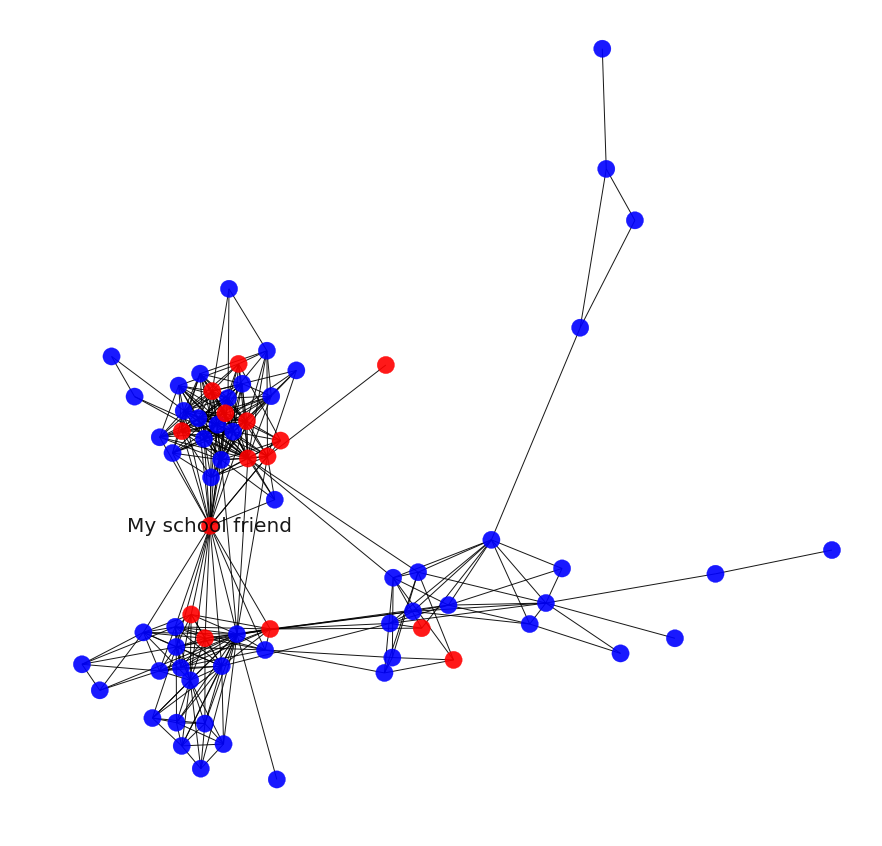

In [201]:
plt.figure(figsize=(15,15))

res = nx.from_dict_of_lists(result1)
nx.draw_networkx(res, alpha=0.9, node_color=colors, cmap=plt.cm.jet, labels={17880393 : 'My school friend'}, font_size=20)

plt.axis('off')
plt.show()

Graph has 72 verticles and 356 edges.

# Analisys

### Degree distribution

As can be seen from the graph, the vertices with the number of edges equal to 5 and 8 are the most.

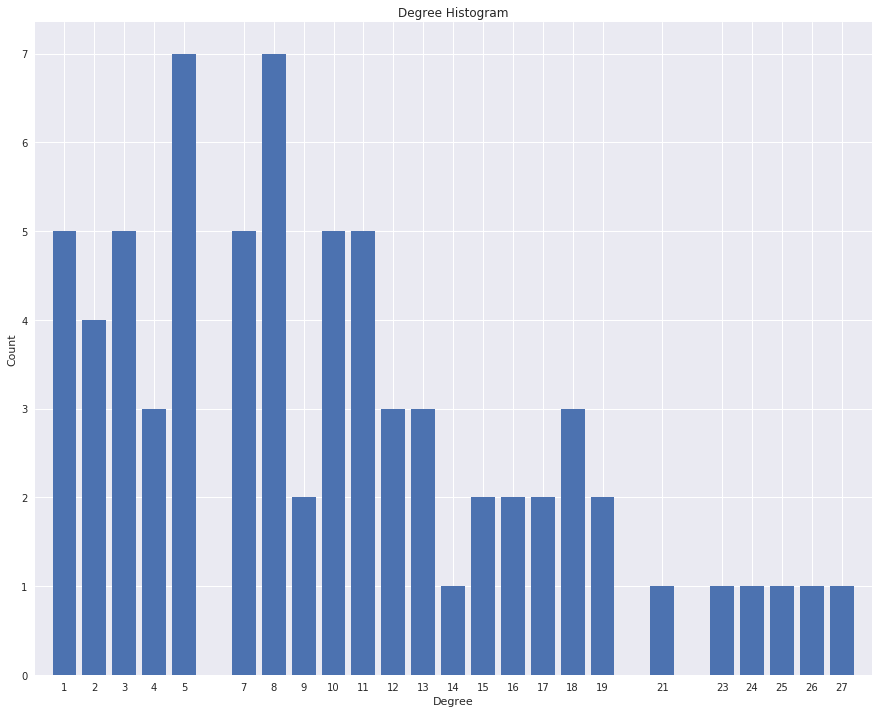

In [245]:
import collections

degree_sequence = sorted([d for n, d in res.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

plt.figure(figsize=(15,12))

plt.bar(deg, cnt, width=0.80)
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.xlim(0, max(deg) + 1)
plt.xticks([d for d in deg])
plt.show()

And pie-chart:

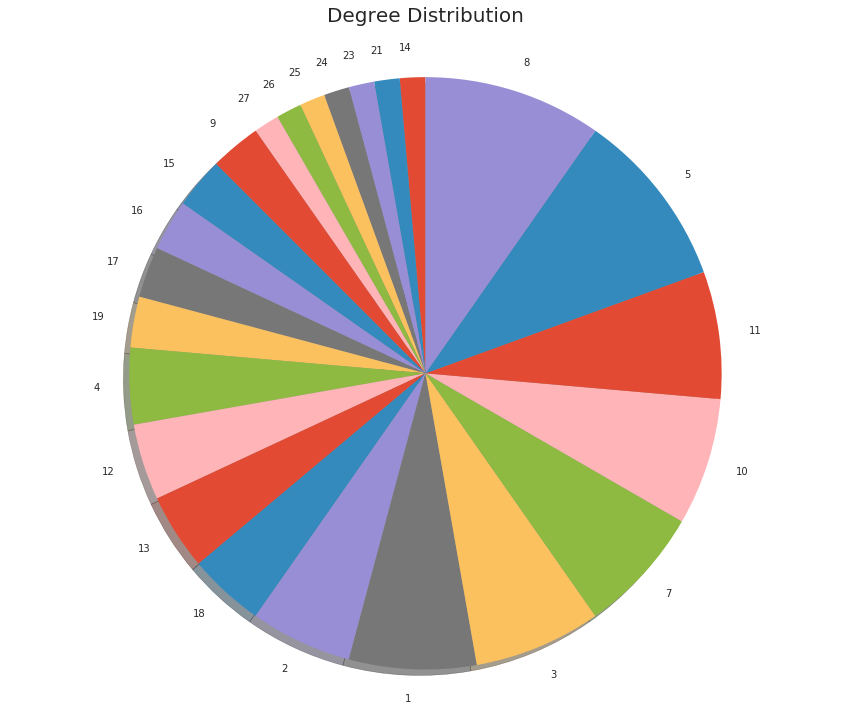

In [238]:
sorted_slice = sorted([i for i in degreeCount.items()], key=lambda x: x[1])
deg, cnt = [i[0] for i in sorted_slice], [i[1] for i in sorted_slice]

plt.figure(figsize=(15,12))
plt.style.use('ggplot')

plt.pie(cnt, labels=deg, shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Degree Distribution', size=20, y=1.03)
plt.show()

### Shortest Path distribution

The most common path length in the graph is 4, which means that most of my friends know each other through a chain of 2 people.

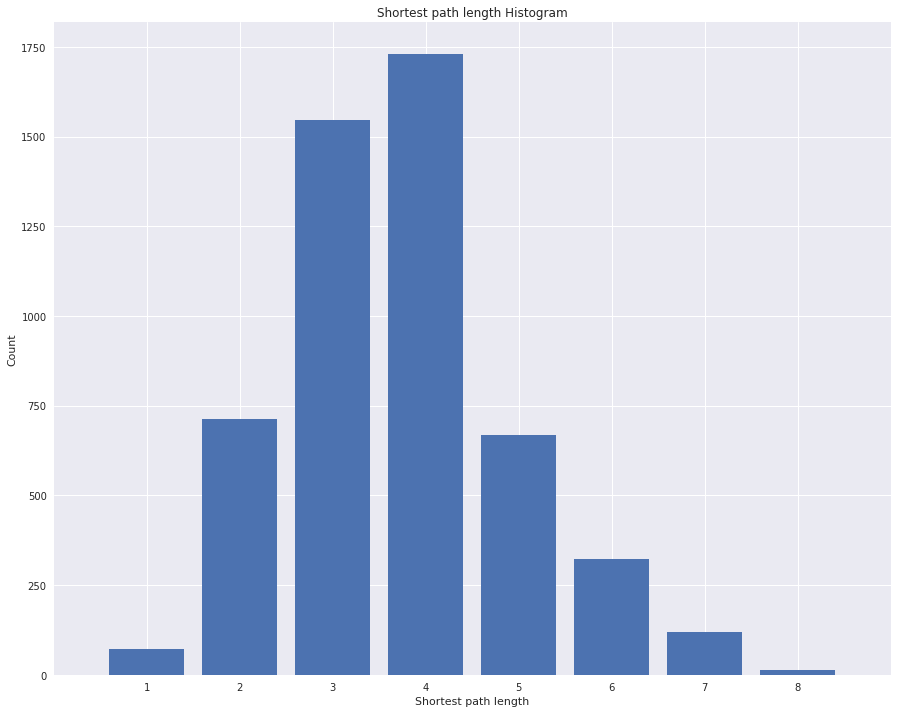

In [244]:
all_path = nx.all_pairs_shortest_path(res)

q = collections.Counter([len(paths) for k, i in all_path for paths in i.values()])
deg, cnt = zip(*q.items())

plt.figure(figsize=(15,12))

plt.bar(deg, cnt, width=0.80)
plt.title("Shortest path length Histogram")
plt.ylabel("Count")
plt.xlabel("Shortest path length")
plt.xlim(0, max(deg) + 1)
plt.xticks([d for d in deg])
plt.show()


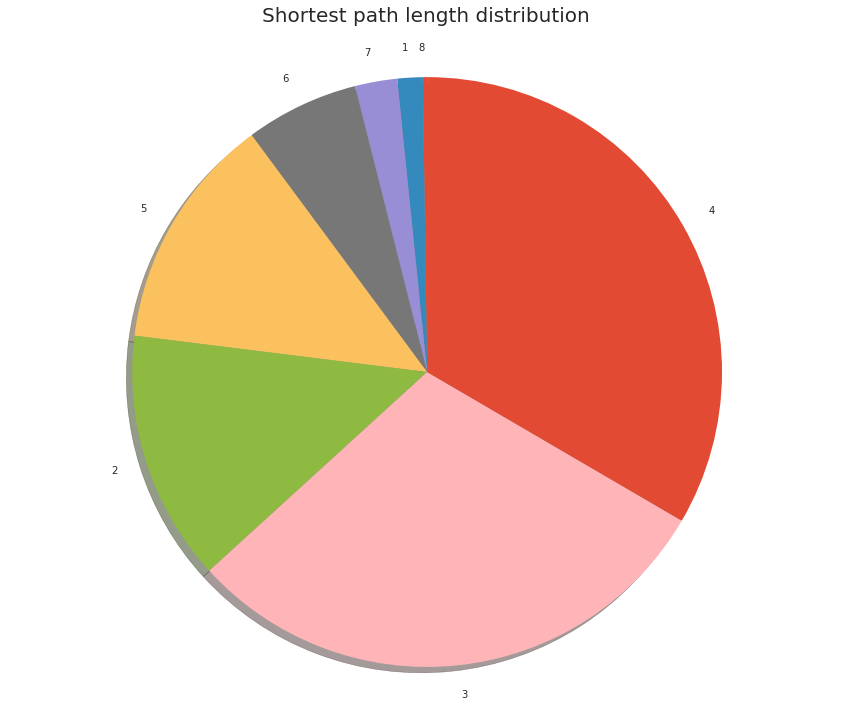

In [237]:
sorted_slice = sorted([i for i in q.items()], key=lambda x: x[1])
deg, cnt = [i[0] for i in sorted_slice], [i[1] for i in sorted_slice]

plt.figure(figsize=(15,12))
plt.style.use('ggplot')

plt.pie(cnt, labels=deg, shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Shortest path length distribution', size=20, y=1.03)
plt.show()

### Diameter, Radius, Center

In [246]:
print('Diameter:', nx.diameter(res))
print('Center:', nx.center(res))
print('Radius:', nx.radius(res))


Diameter: 7
Center: [196301700, 341452870, 374450143, 16035041, 228163684, 278267878, 67849056, 273877653]
Radius: 4


Big blue verticles are central.

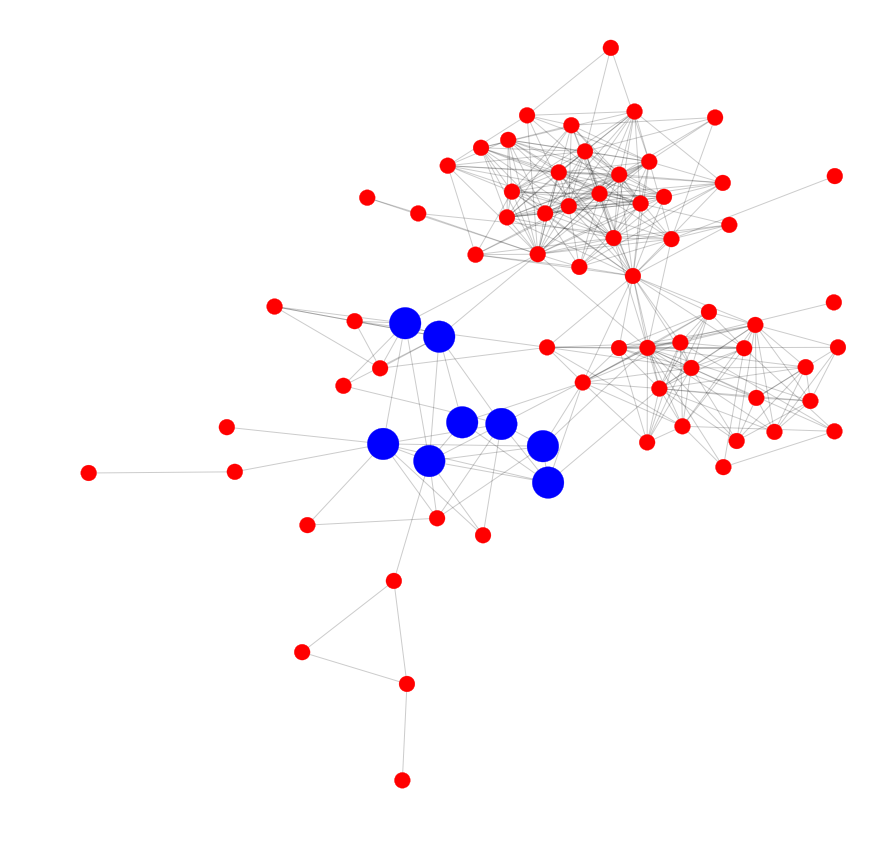

In [112]:
plt.figure(figsize=(15,15))

pos = nx.kamada_kawai_layout(res)

center_nodes = nx.center(res)

node_colors, node_sizes = [], []
for i in res.nodes():
    if i in center_nodes:
        node_colors.append('blue')
        node_sizes.append(1000)
    else:
        node_sizes.append(250)
        node_colors.append('red')

# nx.draw_kamada_kawai(res, with_labels=True)

# ec = nx.draw_kamada_kawai(res, alpha=0.85, node_color=node_colors, node_size=node_sizes)
pos = nx.kamada_kawai_layout(res)
ec = nx.draw_networkx_edges(res, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(res, pos, node_color=node_colors, node_size=node_sizes)

plt.axis('off')
plt.show()

### Clustering Coefficients

As it is observed, graph has pretty big clustering coefficent, which means almost everyone knows each other.

In [251]:
print('Clustering coefficent:', nx.average_clustering(res))

Clustering coefficent: 0.6303389756818139


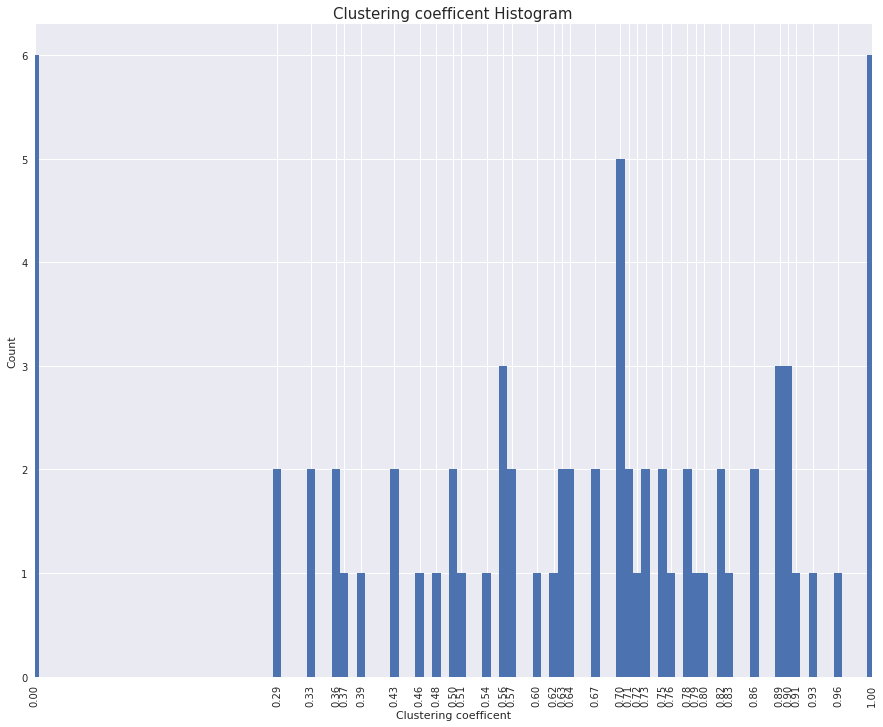

In [250]:
q = collections.Counter([round(i, 2) for i in nx.clustering(res).values()])
deg, cnt = zip(*q.items())

plt.figure(figsize=(15,12))

plt.bar(deg, cnt, width=0.01)
# plt.hist([i for i in nx.clustering(res).values()], bins=70)
plt.title("Clustering coefficent Histogram", size=15)
plt.ylabel("Count")
plt.xlabel("Clustering coefficent")
plt.xlim(0, 1)
plt.xticks([d for d in deg], rotation='vertical')
plt.show()

### Degree/Closeness/Betweenness centralities

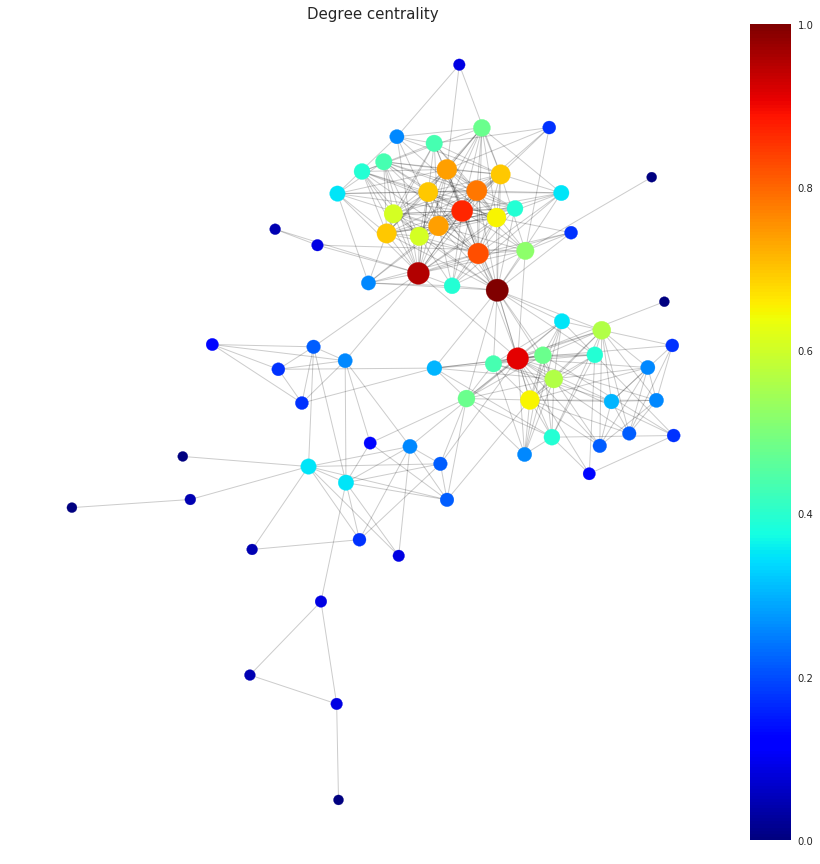

In [256]:
from itertools import count, islice

degree_centrality = nx.degree_centrality(res)

nx.set_node_attributes(res, degree_centrality, "degree_centrality")

groups = set(nx.get_node_attributes(res, "degree_centrality").values())
mapping = dict(zip(sorted(groups),count()))
nodes = res.nodes()
colors = [mapping[res.node[n]["degree_centrality"]] / 23 for n in nodes]
node_sizes = [(i*400)+100 for i in colors]

plt.figure(figsize=(15,15))

pos = nx.kamada_kawai_layout(res)
ec = nx.draw_networkx_edges(res, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(res, pos, nodelist=nodes, node_color=colors, node_size=node_sizes, cmap=plt.cm.jet)

plt.title('Degree centrality', size=15)
plt.colorbar(nc)
plt.axis('off')
plt.show()

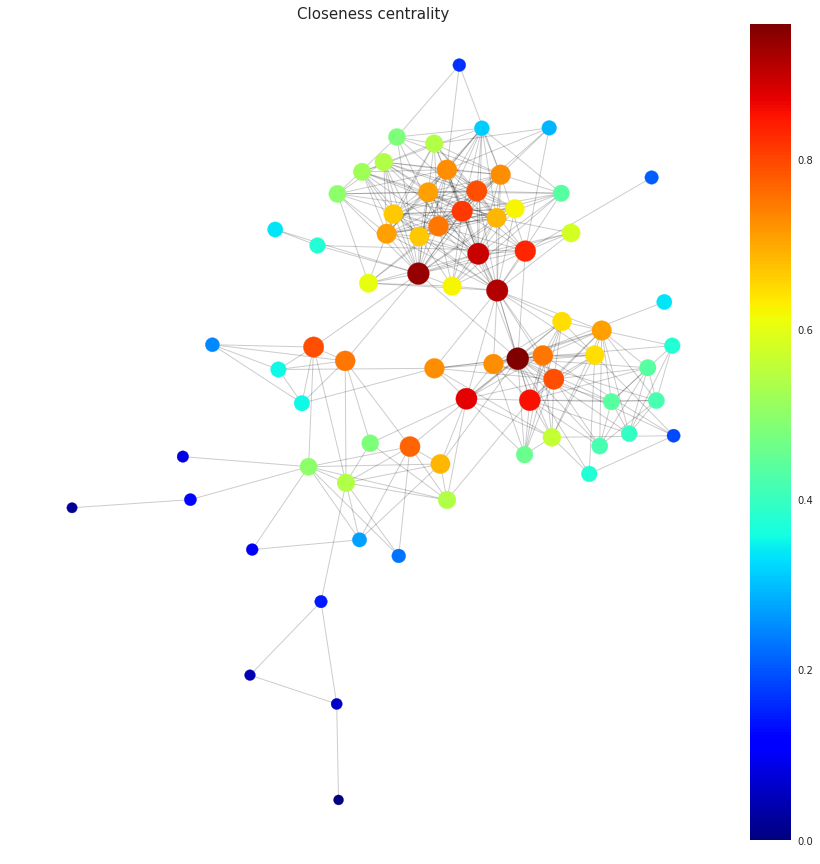

In [255]:
from itertools import count

closeness_centrality = nx.closeness_centrality(res)

nx.set_node_attributes(res, closeness_centrality, "closeness_centrality")

groups = set(nx.get_node_attributes(res, "closeness_centrality").values())
mapping = dict(zip(sorted(groups),count()))
nodes = res.nodes()
colors = [mapping[res.node[n]["closeness_centrality"]] / 48 for n in nodes]
node_sizes = [(i*400)+100 for i in colors]

plt.figure(figsize=(15,15))

pos = nx.kamada_kawai_layout(res)
ec = nx.draw_networkx_edges(res, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(res, pos, nodelist=nodes, node_color=colors, node_size=node_sizes, cmap=plt.cm.jet)

plt.title('Closeness centrality', size=15)
plt.colorbar(nc)
plt.axis('off')
plt.show()

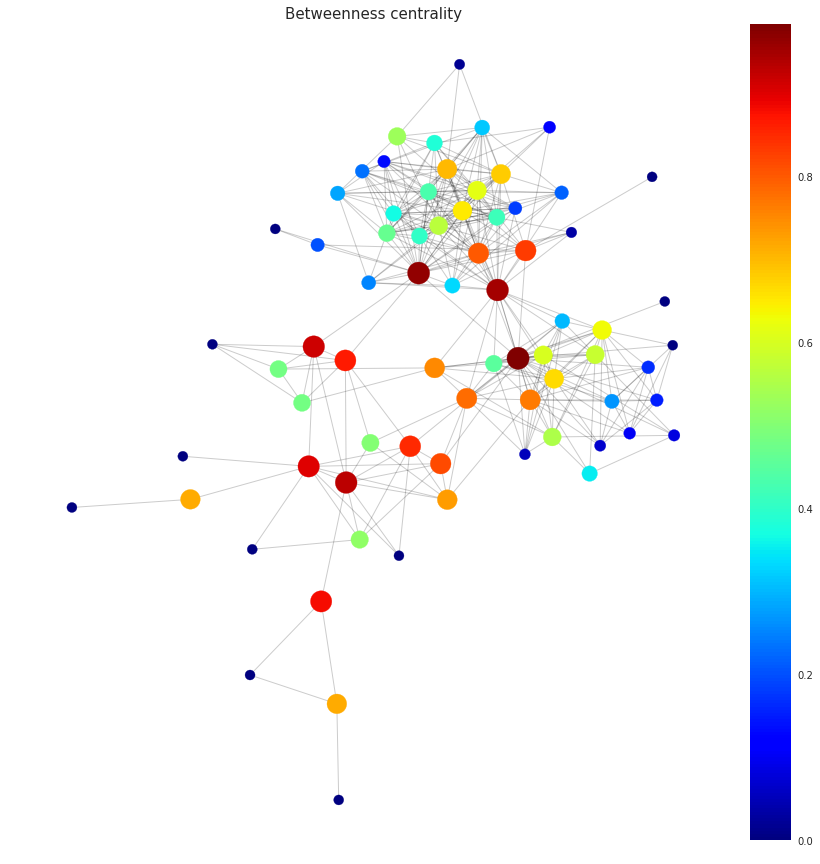

In [254]:
from itertools import count

betweenness_centrality = nx.betweenness_centrality(res)

nx.set_node_attributes(res, betweenness_centrality, "betweenness_centrality")

groups = set(nx.get_node_attributes(res, "betweenness_centrality").values())
mapping = dict(zip(sorted(groups),count()))
nodes = res.nodes()
colors = [mapping[res.node[n]["betweenness_centrality"]] / 60 for n in nodes]
node_sizes = [(i*400)+100 for i in colors]

plt.figure(figsize=(15,15))

pos = nx.kamada_kawai_layout(res)
ec = nx.draw_networkx_edges(res, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(res, pos, nodelist=nodes, node_color=colors, node_size=node_sizes, cmap=plt.cm.jet)

plt.title('Betweenness centrality', size=15)
plt.colorbar(nc)
plt.axis('off')
plt.show()

### Top nodes interpretation

In [270]:
top_closeness = sorted([i for i in closeness_centrality.keys()], key=lambda x: closeness_centrality[x], reverse=True)
top_betw = sorted([i for i in betweenness_centrality.keys()], key=lambda x: betweenness_centrality[x], reverse=True)
top_degree = sorted([i for i in degree_centrality.keys()], key=lambda x: degree_centrality[x], reverse=True)

print ('Top by closeness:')
for i in top_closeness[:3]:
    print (all_friends[i]['last_name'], all_friends[i]['first_name'])

print()
print ('Top by betweenness:')
for i in top_betw[:3]:
    print (all_friends[i]['last_name'], all_friends[i]['first_name'])

print()
print ('Top by degree:')
for i in top_degree[:3]:
    print (all_friends[i]['last_name'], all_friends[i]['first_name'])



Top by closeness:
Плотников Георгий
Павлов Сергей
Чижова Даша

Top by betweenness:
Плотников Георгий
Павлов Сергей
Чижова Даша

Top by degree:
Чижова Даша
Павлов Сергей
Плотников Георгий


For all 3x metrics, 3 vertices with the highest value are clearly visible: 1 the vertex belongs to the cluster 'school', 1 to the cluster 'university' and 1 between them (I wrote about it earlier). This, of course, is my friend from school, my friend from University and a school friend who came with me to the university.

### Page-Rank. Comparison with centralities

Again, there are the same persons.

In [273]:

top_rank = sorted(nx.pagerank(res).items(), key=lambda x: x[1], reverse=True)[:3]
print('Page Rank:')

for i in top_rank[:3]:
    print (all_friends[i[0]]['last_name'], all_friends[i[0]]['first_name'], i[1])

Page Rank:
Плотников Георгий 0.03426548281742275
Павлов Сергей 0.030152489726071815
Чижова Даша 0.029453479498658883


### Assortative Mixing according to node attributes

The coefficient is rather low, which means that people are connected regardless of sex.

In [142]:
nx.attribute_assortativity_coefficient(res,'sex')

0.06723635208868595

### Node structural equivalence/similarity

In my graph there are no verticles that belongs to same equivalent class. This is logical, because if people have a common circle of communication, most likely they are also friends or at least know each other.

In [276]:
# structural equivalence
same_neighbors = lambda u, v: (u not in res[v] and v not in res[u] and res[u] == res[v])

Q = nx.quotient_graph(res, same_neighbors)

# Q.nodes() is a list of sets of equivalent classes
if False in [len(i) == 1 for i in Q.nodes()]: print ('Equivalent class is present')

### The closest random graph model similar to your SN

I created several graphs using Erdos-Reni, Barabasi-Albert and Watts-Strogats random graph models and metrics from my own graph.

In [275]:
nodes_count = len(res.nodes())

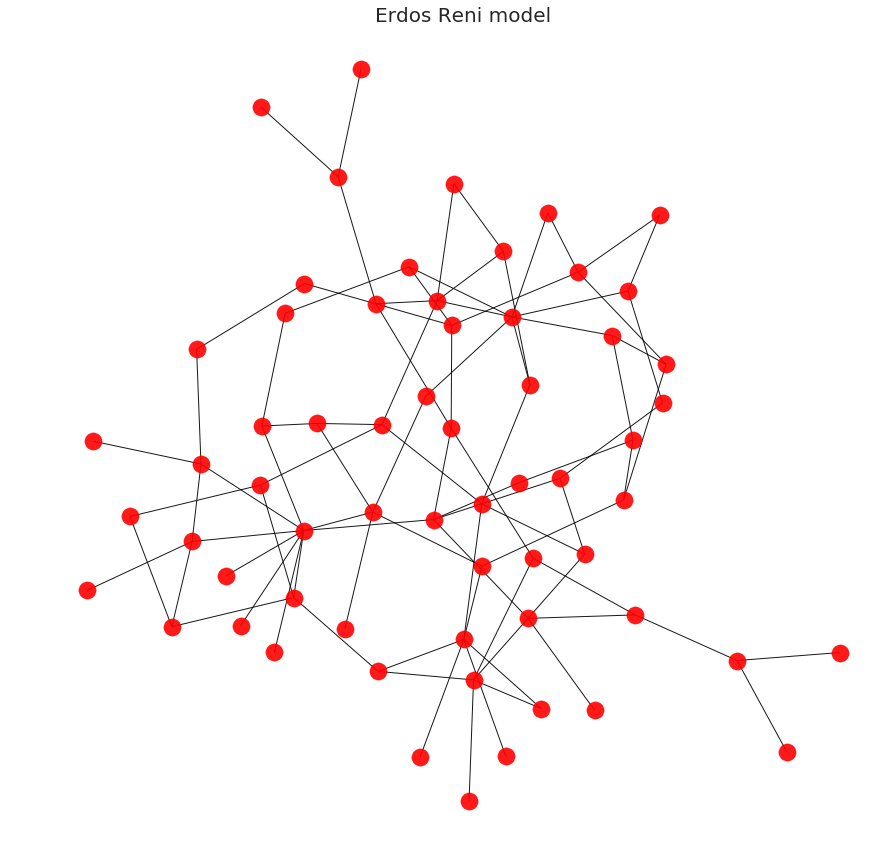

In [276]:
# calculate edge spawn probability
p_param = len(res.edges()) / (len(res.nodes()) * (len(res.nodes()) - 1)) / 2

erd = nx.erdos_renyi_graph(nodes_count, p_param)

# clear from solo nodes
for i in list(erd.degree()):
    if i[1] == 0: erd.remove_node(i[0])
    

plt.figure(figsize=(15,15))
plt.title('Erdos Reni model', size=20)

nx.draw_kamada_kawai(erd, alpha=0.9)

plt.show()

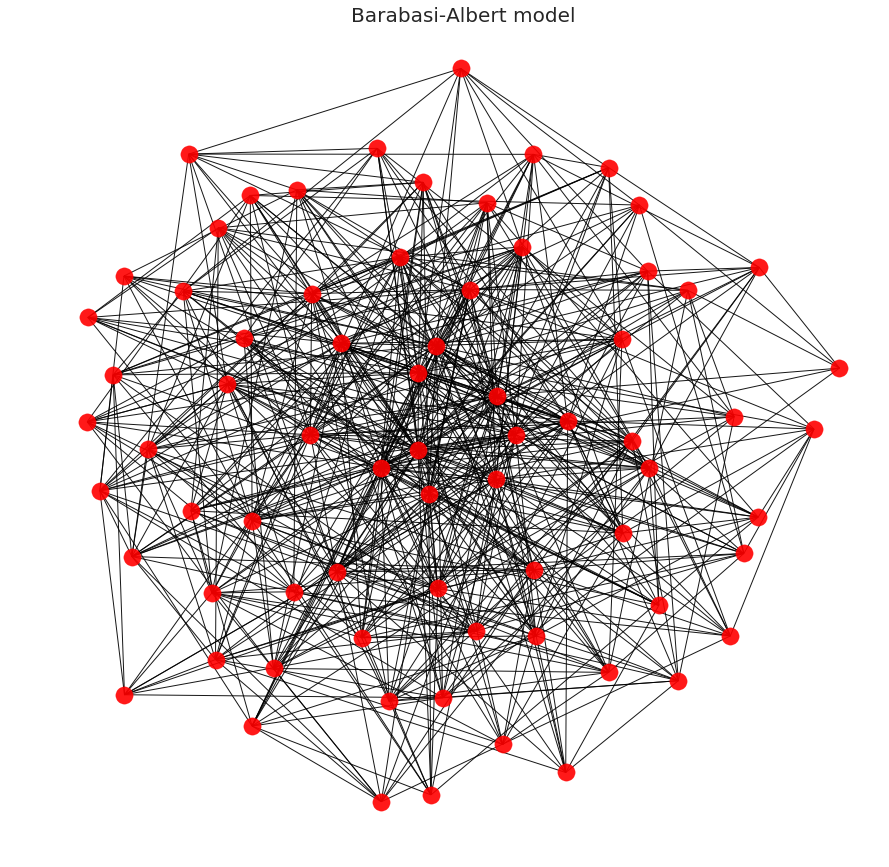

In [279]:
# calculating average degree of nodes
average_degree = sum([i[1] for i in res.degree()]) / nodes_count

bara = nx.barabasi_albert_graph(nodes_count, round(average_degree))

plt.figure(figsize=(15,15))
plt.title('Barabasi-Albert model', size=20)

nx.draw_kamada_kawai(bara, alpha=0.9)

plt.show()

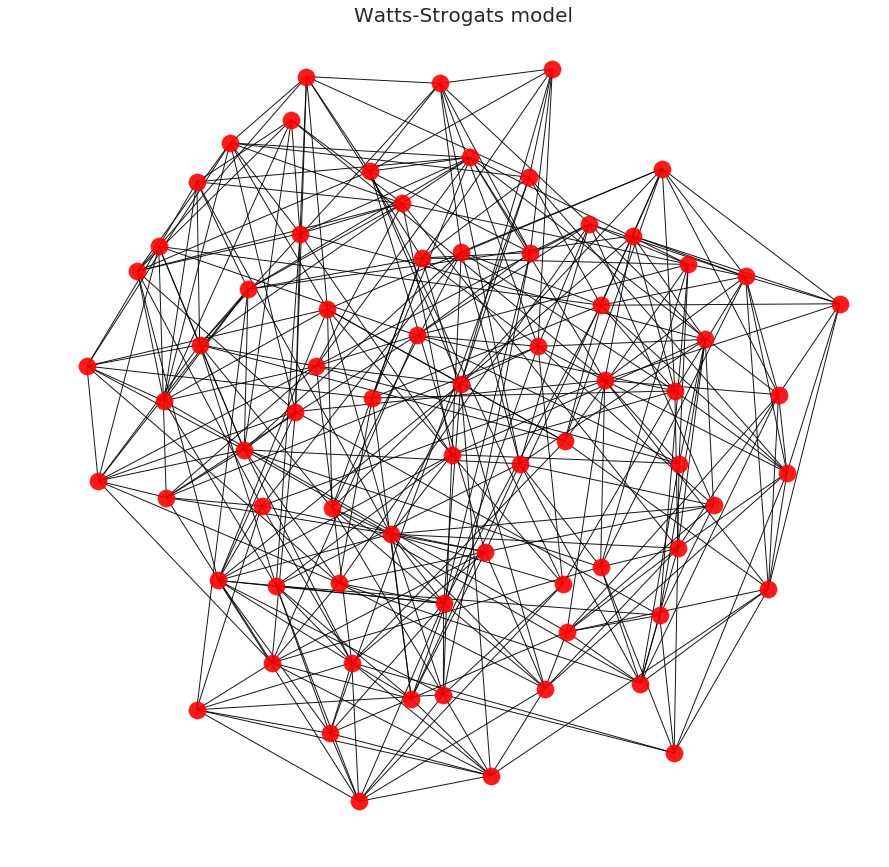

In [282]:
clustering = nx.average_clustering(res)

watts = nx.watts_strogatz_graph(nodes_count, round(average_degree), 1 - clustering)

plt.figure(figsize=(15,15))
plt.title('Watts-Strogats model', size=20)

nx.draw_kamada_kawai(watts, alpha=0.9)

plt.show()

In [283]:
import pandas as pd

edges_num = lambda x: len(x.edges())
av_degree = lambda x: sum([i[1] for i in x.degree()]) / nodes_count

graphs = [res, bara, erd, watts]

funcs_to_check = [nx.average_clustering, nx.average_shortest_path_length,
                  nx.diameter, av_degree, edges_num]

compare_table = []
for i in graphs:
    compare_table.append([f(i) for f in funcs_to_check])
    
df = pd.DataFrame(compare_table, columns=['Clustering coefficent', 'Average path length',
                                          'Diameter', 'Average degree', 'Edges num'],
                 index=['Original', 'Barabasi-Albert', 'Erdos-Reni', 'Watts-Strogats'])

df

Clustering coefficent  Average path length  Diameter  \
Original                      0.630339             2.755477         7   
Barabasi-Albert               0.342684             1.770736         3   
Erdos-Reni                    0.028943             3.938657         8   
Watts-Strogats                0.244006             2.129499         3   

                 Average degree  Edges num  
Original               9.888889        356  
Barabasi-Albert       17.222222        620  
Erdos-Reni             2.472222         89  
Watts-Strogats        10.000000        360

In this table, you can see quite clearly that the metrics of my graph are most similar to that of a graph created using a Watts-Strogats model.

# Community Detection

### Cliques, Hierarchical k-cores, k-plexes

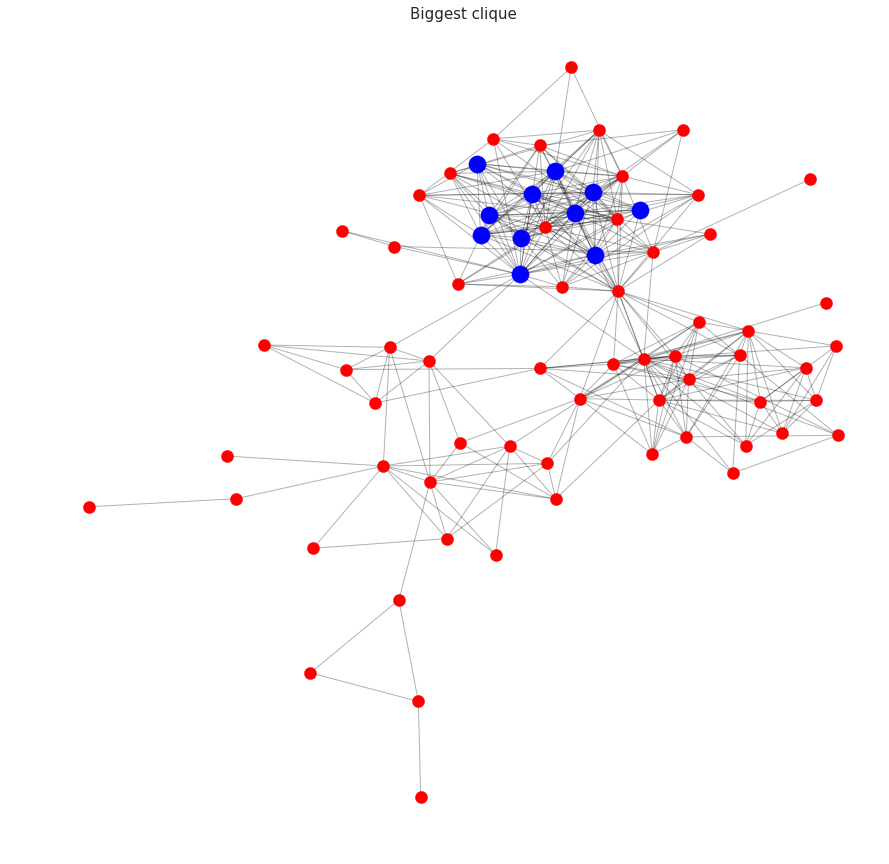

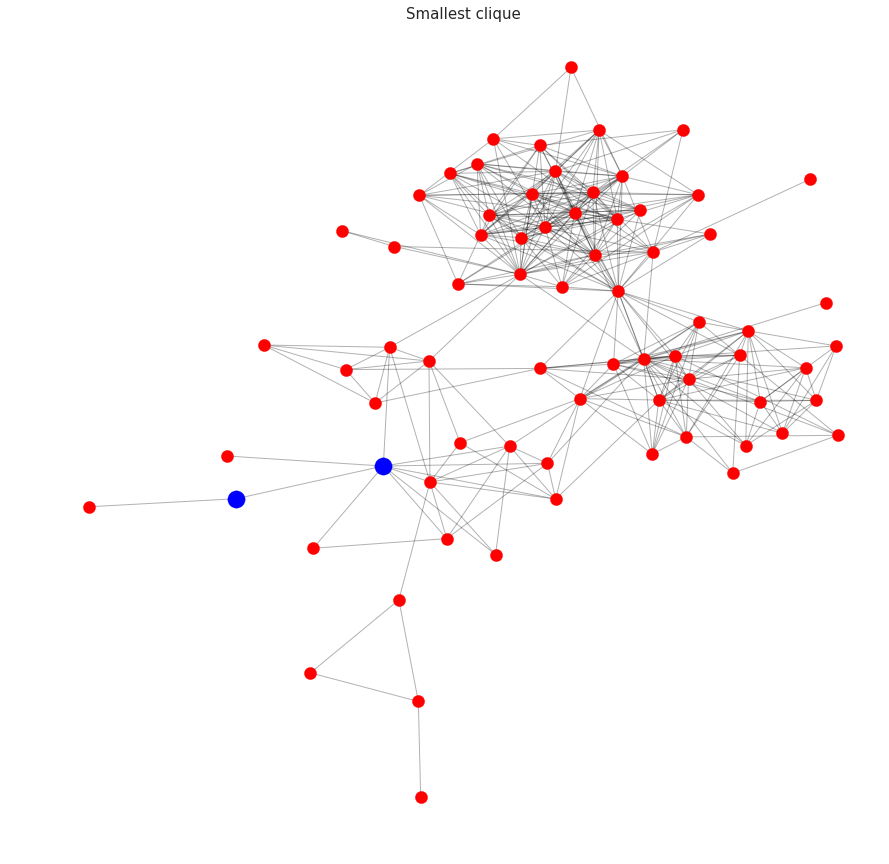

In [348]:
cliques = list(nx.find_cliques(res))
cliques_list = sorted(cliques, key=lambda x : len(x), reverse=True)

pos = nx.kamada_kawai_layout(res)

plt.figure(figsize=(15,15))
nx.draw_networkx_edges(res, pos, alpha=0.3)
clique_nodes = nx.draw_networkx_nodes(res, pos, nodelist=cliques_list[0], node_color="blue", with_labels=False, node_size=300)
not_cl_nodes = nx.draw_networkx_nodes(res, pos, nodelist=[n for n in res.nodes if n not in cliques_list[0]], node_size=150)

plt.title('Biggest clique', size=15)
plt.axis('off')
plt.show()

plt.figure(figsize=(15,15))
nx.draw_networkx_edges(res, pos, alpha=0.3)
clique_nodes = nx.draw_networkx_nodes(res, pos, nodelist=cliques_list[-1], node_color="blue", with_labels=False, node_size=300)
not_cl_nodes = nx.draw_networkx_nodes(res, pos, nodelist=[n for n in res.nodes if n not in cliques_list[-1]], node_size=150)

plt.title('Smallest clique', size=15)
plt.axis('off')
plt.show()

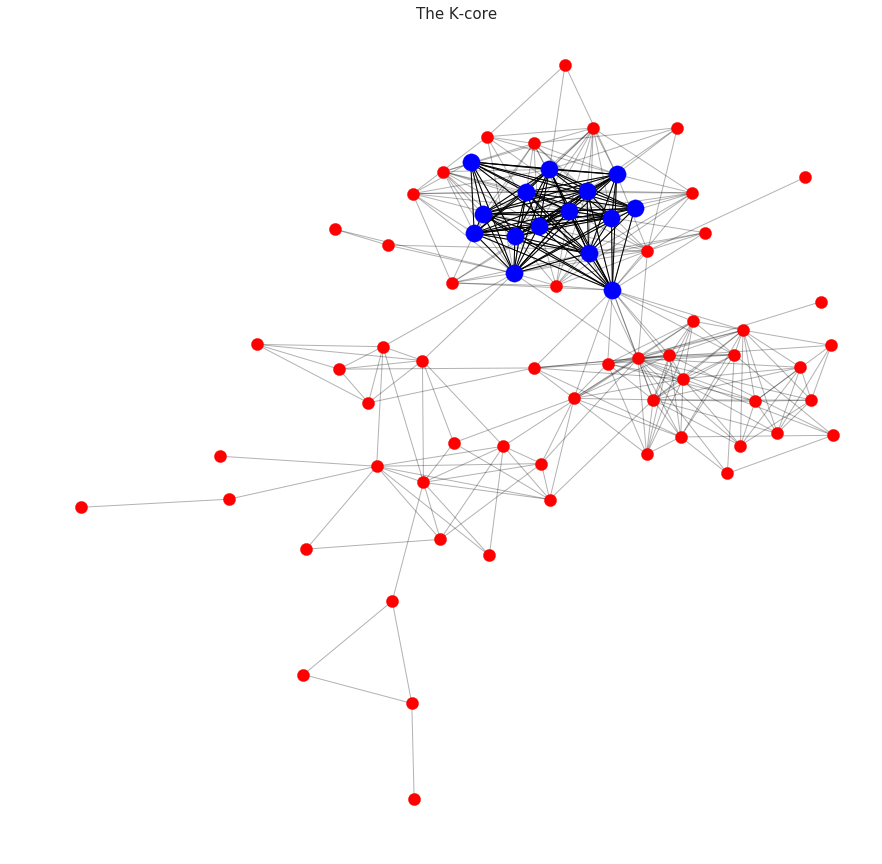

In [350]:
kcore = nx.k_core(res)


pos = nx.kamada_kawai_layout(res)

plt.figure(figsize=(15,15))
nx.draw_networkx_edges(res, pos, alpha=0.3)
nx.draw_networkx_edges(kcore, pos)
all_nodes = nx.draw_networkx_nodes(kcore, pos, nodelist=res.nodes(), node_size=150)
kcore_nodes = nx.draw_networkx_nodes(kcore, pos, nodelist=kcore.nodes(), node_color="blue", with_labels=False, node_size=300)

plt.title('The K-core', size=15)
plt.axis('off')
plt.show()

## Community detection algorithms

The algorithm showed a fast work speed, but the results are not very impressive, since the communities found in most cases were only small parts of the real ones.

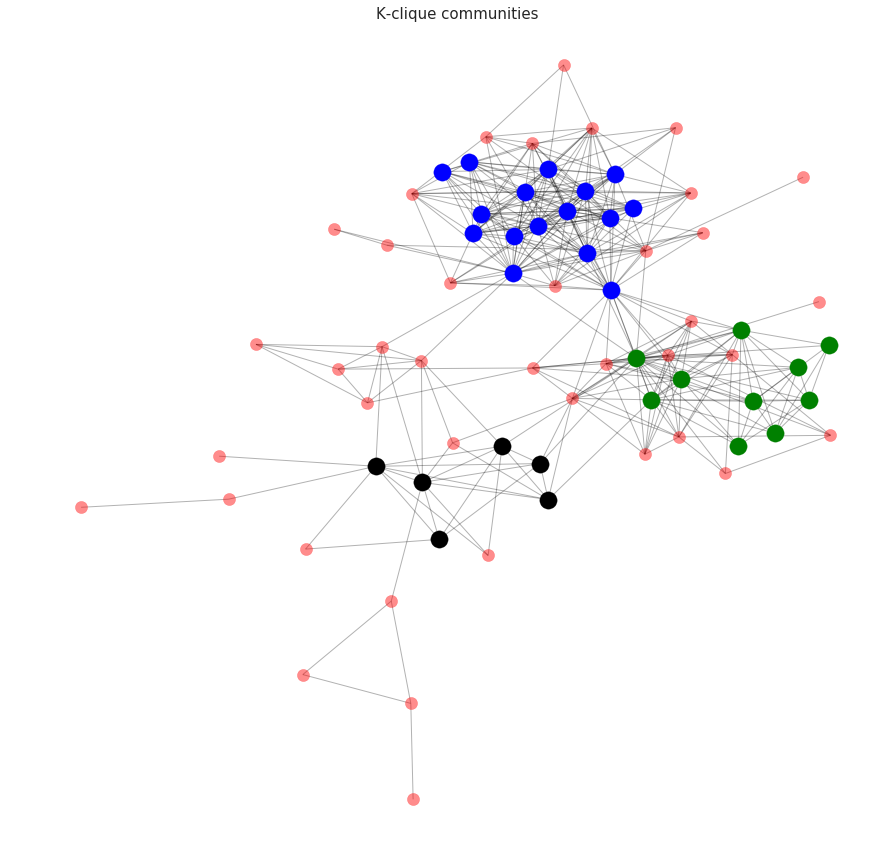

In [285]:
from networkx.algorithms.community import *

cliq_com = next(k_clique_communities(res, 10))

sep_com = []
for i in [9, 8, 7, 6, 5]:
    communities = k_clique_communities(res, i)
    for i in communities:
        if len(cliq_com & i) == 0:
            sep_com.append(i)
    
pos = nx.kamada_kawai_layout(res)

plt.figure(figsize=(15,15))
nx.draw_networkx_edges(res, pos, alpha=0.3)
all_nodes = nx.draw_networkx_nodes(res, pos, alpha=0.45, node_size=150)
kcore_nodes = nx.draw_networkx_nodes(list(cliq_com), pos, nodelist=list(cliq_com), node_color="blue", node_size=300)
kcore_nodes = nx.draw_networkx_nodes(list(sep_com[1]), pos, nodelist=list(sep_com[1]), node_color="green", node_size=300)
kcore_nodes = nx.draw_networkx_nodes(list(sep_com[2]), pos, nodelist=list(sep_com[2]), node_color="black", node_size=300)

# kcore_nodes = nx.draw_networkx_nodes(cliq_com[8], pos, nodelist=cliq_com[8], node_color="yellow",node_size=300)

plt.title('K-clique communities', size=15)
plt.axis('off')
plt.show()

The algorithm is one of the slowest, but it can be called one of the best. The probability of giving an incorrect result is practically equal to zero and even if there is an error, it is insignificant.

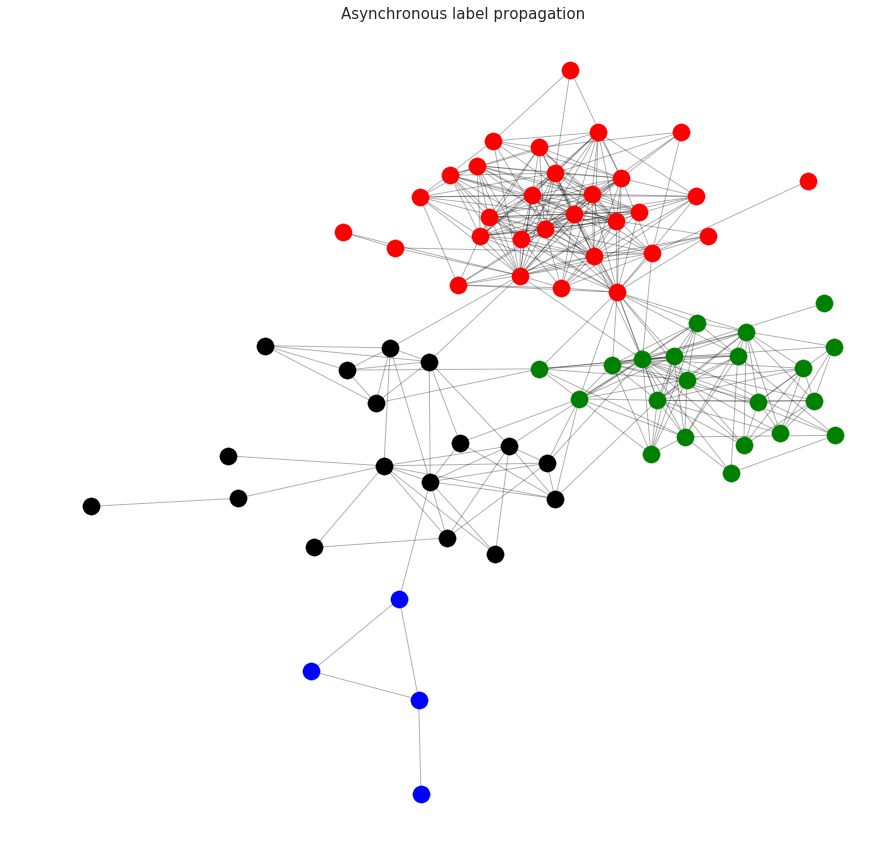

In [297]:
async_com = [i for i in asyn_lpa_communities(res)]

pos = nx.kamada_kawai_layout(res)

plt.figure(figsize=(15,15))
nx.draw_networkx_edges(res, pos, alpha=0.3)
all_nodes = nx.draw_networkx_nodes(res, pos, alpha=0.45, node_size=150)
color = ['blue', 'red', 'green', 'black', 'yellow', 'pink', 'orange']
for i in range(len(async_com)):
    nx.draw_networkx_nodes(list(async_com[i]), pos, nodelist=list(async_com[i]), node_color=color[i], node_size=300)
# kcore_nodes = nx.draw_networkx_nodes(list(cliq_com[1]), pos, nodelist=list(cliq_com[1]), node_color="green", node_size=300)
# kcore_nodes = nx.draw_networkx_nodes(cliq_com[8], pos, nodelist=cliq_com[8], node_color="yellow",node_size=300)

plt.title('Asynchronous label propagation', size=15)
plt.axis('off')
plt.show()

Differs from the previous work speed, exceeding the previous analog at times.

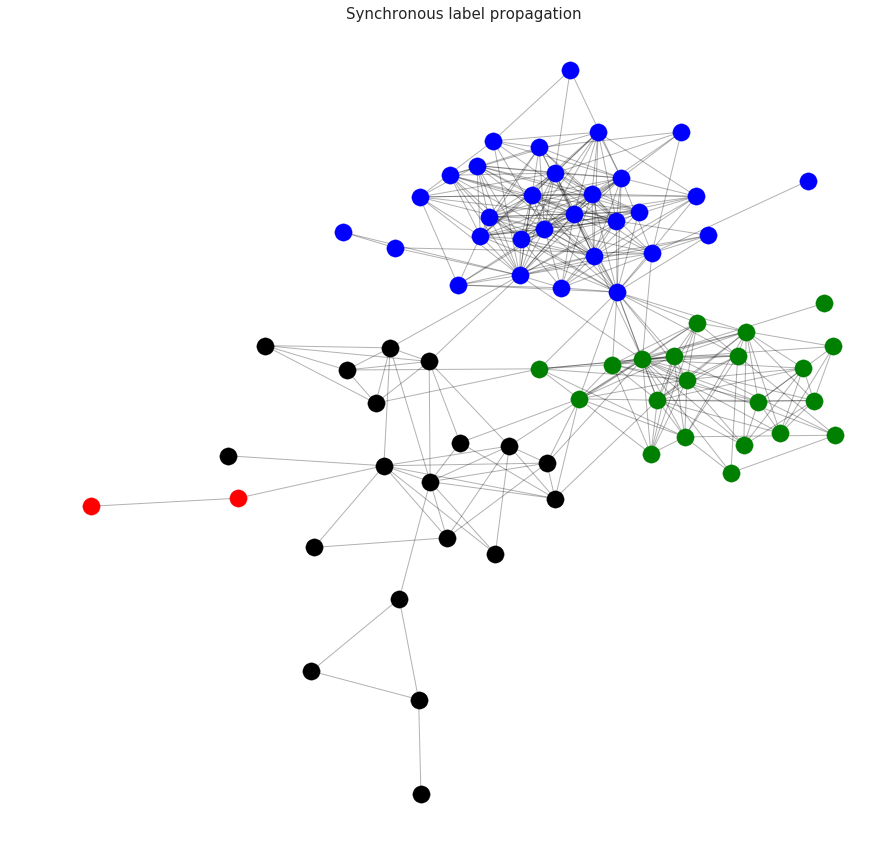

In [298]:
async_com = [i for i in label_propagation_communities(res)]

pos = nx.kamada_kawai_layout(res)

plt.figure(figsize=(15,15))
nx.draw_networkx_edges(res, pos, alpha=0.3)
all_nodes = nx.draw_networkx_nodes(res, pos, alpha=0.45, node_size=150)
color = ['blue', 'red', 'green', 'black', 'yellow', 'pink', 'orange']
for i in range(len(async_com)):
    nx.draw_networkx_nodes(list(async_com[i]), pos, nodelist=list(async_com[i]), node_color=color[i], node_size=300)
# kcore_nodes = nx.draw_networkx_nodes(list(cliq_com[1]), pos, nodelist=list(cliq_com[1]), node_color="green", node_size=300)
# kcore_nodes = nx.draw_networkx_nodes(cliq_com[8], pos, nodelist=cliq_com[8], node_color="yellow",node_size=300)

plt.title('Synchronous label propagation', size=15)
plt.axis('off')
plt.show()

Fast, however, an extremely unreliable algorithm that gives an error in half the cases - can even divide a clear cluster into 2 parts.

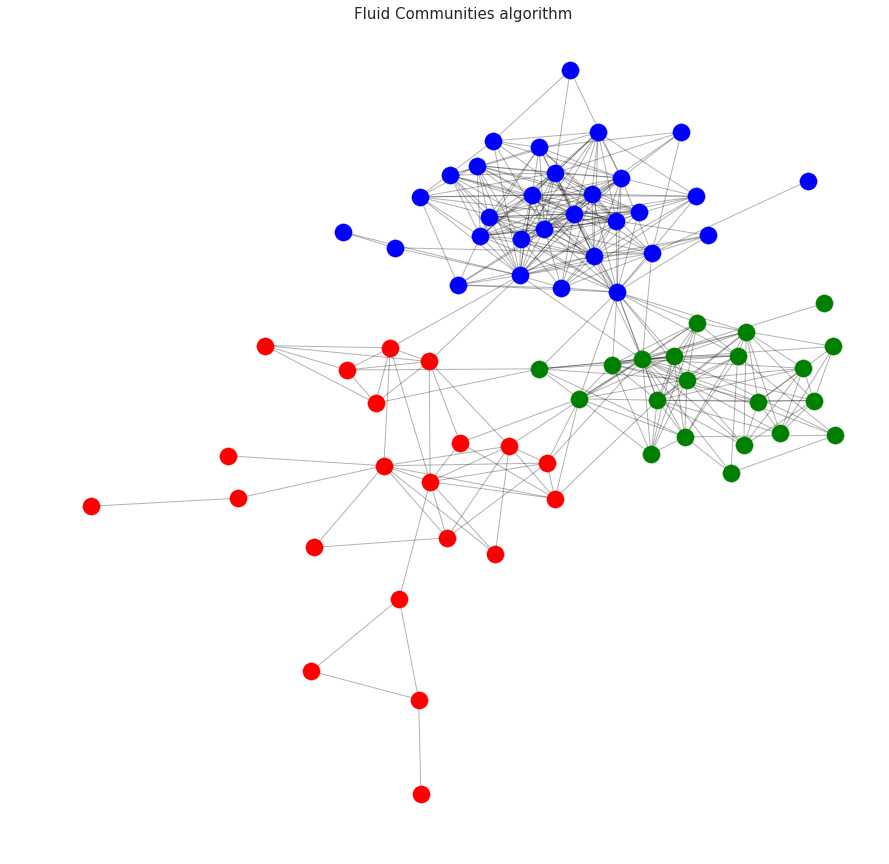

In [336]:
fluid_com = [i for i in asyn_fluidc(res, 3)]

pos = nx.kamada_kawai_layout(res)

plt.figure(figsize=(15,15))
nx.draw_networkx_edges(res, pos, alpha=0.3)
all_nodes = nx.draw_networkx_nodes(res, pos, alpha=0.45, node_size=150)
color = ['blue', 'red', 'green', 'black', 'yellow', 'pink', 'orange']
for i in range(len(fluid_com)):
    nx.draw_networkx_nodes(list(fluid_com[i]), pos, nodelist=list(fluid_com[i]), node_color=color[i], node_size=300)
# kcore_nodes = nx.draw_networkx_nodes(list(cliq_com[1]), pos, nodelist=list(cliq_com[1]), node_color="green", node_size=300)
# kcore_nodes = nx.draw_networkx_nodes(cliq_com[8], pos, nodelist=cliq_com[8], node_color="yellow",node_size=300)

plt.title('Fluid Communities algorithm', size=15)
plt.axis('off')
plt.show()



It produces good results, but it works very long.

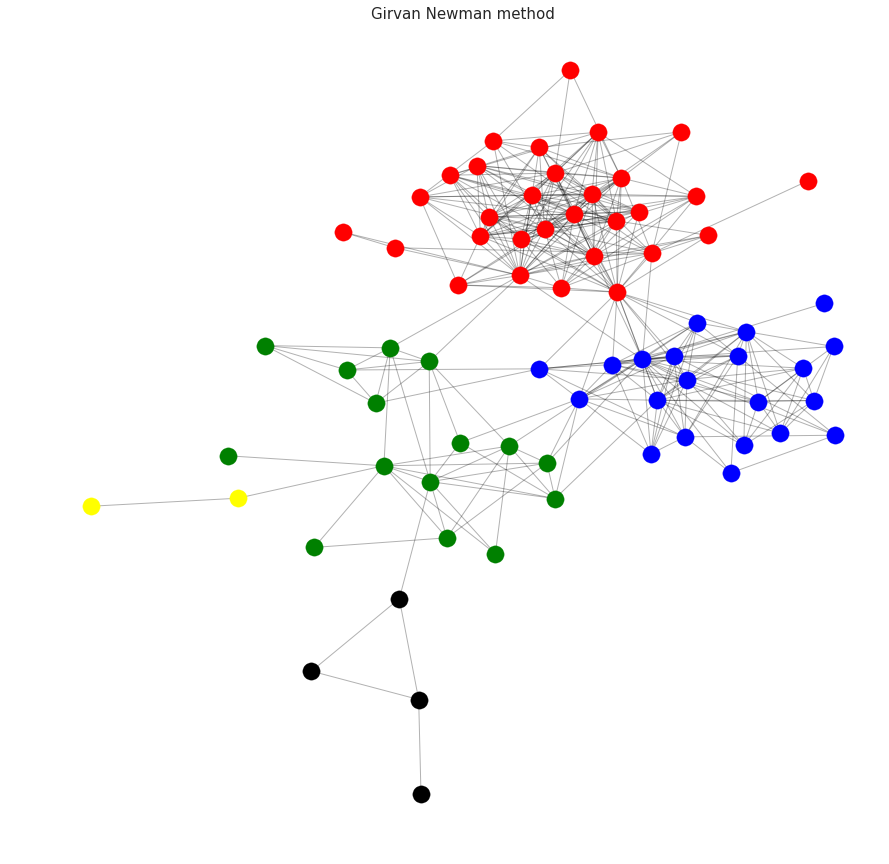

In [141]:
comp = girvan_newman(res)

girvan_com = []
for communities in islice(comp, 4):
    girvan_com.append(tuple(sorted(c) for c in communities))
girvan_com = girvan_com[-1]
pos = nx.kamada_kawai_layout(res)

plt.figure(figsize=(15,15))
nx.draw_networkx_edges(res, pos, alpha=0.3)
all_nodes = nx.draw_networkx_nodes(res, pos, alpha=0.45, node_size=150)
color = ['blue', 'red', 'green', 'black', 'yellow', 'pink', 'orange']
for i in range(len(girvan_com)):
    nx.draw_networkx_nodes(list(girvan_com[i]), pos, nodelist=list(girvan_com[i]), node_color=color[i], node_size=300)

plt.title('Girvan Newman method', size=15)
plt.axis('off')
plt.show()


One of the best algorithms, combining high speed and quality.

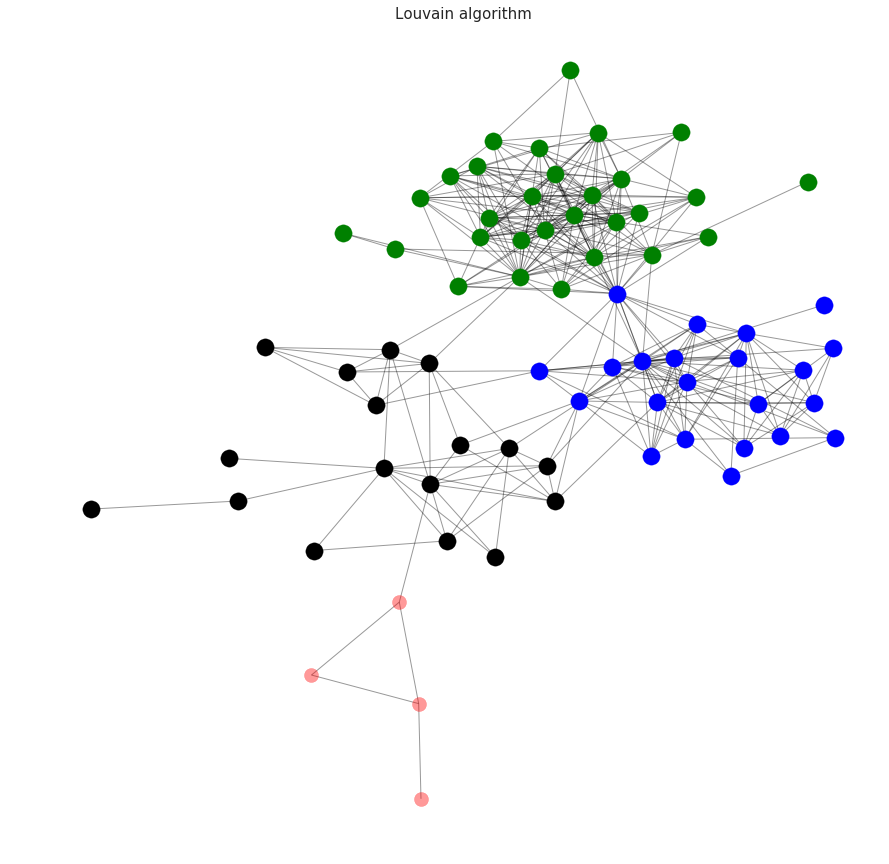

In [171]:
from community import *

part = best_partition(res)
com_count = max([i for i in part.values()])

communities = []
for i in range(com_count):
    communities.append([key for key, item in part.items() if item == i])    

pos = nx.kamada_kawai_layout(res)

plt.figure(figsize=(15,15))
nx.draw_networkx_edges(res, pos, alpha=0.4)
nx.draw_networkx_nodes(res, pos, alpha=0.4, node_size=200)

color = ['blue', 'green', 'black', 'yellow', 'pink', 'orange']

for num, i in enumerate(communities):
    nx.draw_networkx_nodes(res, pos, nodelist=i, node_color=color[num], with_labels=False, node_size=300)
# clique_nodes = nx.draw_networkx_nodes(res, pos, nodelist=cliques_list[0], node_color="blue", with_labels=False, node_size=300)
# not_cl_nodes = nx.draw_networkx_nodes(res, pos, nodelist=[n for n in res.nodes if n not in cliques_list[0]], node_size=150)

plt.title('Louvain algorithm', size=15)
plt.axis('off')
plt.show()